# Prediction of drug release type with Random Forest (RF)
## Initialization of environment

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import os
from optuna.samplers import TPESampler
import warnings
optuna.logging.set_verbosity(optuna.logging.ERROR)
warnings.filterwarnings("ignore")

## Data loading and preparation
Definition of variables, data loading, normalization and interpolation of the drug release profile, calculation of drug release profile AUC, and definition of drug release type (burst: AUC > 0.5, delayed: AUC <= 0.5)

In [6]:
num_interp_pts = 11
n_outer_folds = 10
n_inner_folds = 2
n_trials = 50
# ----------------------------------------------------------------------------------------
# Load data
# ----------------------------------------------------------------------------------------
file_path_form = 'mp_dataset_processed_no_dupes.xlsx'
file_path_time = 'mp_dataset_processed_time_release_only.xlsx'
formulation_df = pd.read_excel(file_path_form, engine='openpyxl')
release_df = pd.read_excel(file_path_time, engine='openpyxl')

# ----------------------------------------------------------------------------------------
# Encode categorical
# ----------------------------------------------------------------------------------------
unique_values_emulsion = formulation_df['Formulation Method'].unique()
mapping = {v: i for i, v in enumerate(unique_values_emulsion)}
formulation_df['Formulation Method Encoded'] = formulation_df['Formulation Method'].map(mapping)
formulation_df.drop(columns=['Formulation Method', 'Drug SMILES'], inplace=True)

# ----------------------------------------------------------------------------------------
# Interpolation
# ----------------------------------------------------------------------------------------
group = release_df.groupby('Formulation Index')['Time']
min_time = group.transform('min')
max_time = group.transform('max')
release_df['Normalized Time'] = (release_df['Time'] - min_time) / (max_time - min_time)
normalized_times = np.linspace(0, 1, num_interp_pts)
interpolated_dfs = []
for formulation, g in release_df.groupby('Formulation Index'):
    g = g.sort_values('Time')
    time_min, time_max = g['Time'].min(), g['Time'].max()
    g['Normalized Time'] = (g['Time'] - time_min) / (time_max - time_min)
    interp_release = np.interp(normalized_times, g['Normalized Time'], g['Release'])
    interpolated_dfs.append(pd.DataFrame({
        'Formulation Index': formulation,
        'Normalized Time': normalized_times,
        'Interpolated Release': interp_release
    }))
interp_df = pd.concat(interpolated_dfs, ignore_index=True)

X = formulation_df.drop(columns=['Formulation Index']).to_numpy()
#X = formulation_df.to_numpy()  # [321, 11]
groups = interp_df.groupby('Formulation Index')['Interpolated Release']

# ----------------------------------------------------------------------------------------
# AUC and drug release type definition
# ----------------------------------------------------------------------------------------
auc = (
    interp_df.groupby("Formulation Index")
      .apply(lambda g: np.trapz(g["Interpolated Release"], g["Normalized Time"]))
      .reset_index(name="AUC")
)

auc['burst'] = (auc['AUC'] > 0.5).astype(int)
y = auc['burst'].values


## Model Definition and Training
Nested cross-validation with optuna hyperparameter optimization

In [20]:
# ----------------------------------------------------------------------------------------
# Model wrapper for Random Forest Classifier
# ----------------------------------------------------------------------------------------
class RandomForestModel:
    def __init__(self, **params):
        self.model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1]  # probability for class 1

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        acc = accuracy_score(y_true, y_pred)
        return acc

    def feature_importances(self):
        return self.model.feature_importances_


# ----------------------------------------------------------------------------------------
# Storage
# ----------------------------------------------------------------------------------------
stored_best_models = []
stored_best_preds = []
stored_best_proba = []
stored_test_targets = []
stored_metrics = []
stored_avg_learning_curves = []
stored_shap_values = []
stored_shap_test_sets = []

# ----------------------------------------------------------------------------------------
# Nested CV setup
# ----------------------------------------------------------------------------------------
outer_kf = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
inner_kf = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=42)

# ----------------------------------------------------------------------------------------
# Outer CV loop
# ----------------------------------------------------------------------------------------
for outer_fold, (train_idx, test_idx) in enumerate(outer_kf.split(X, y)):
    print(f"\nOuter Fold {outer_fold + 1}")

    X_train_val, y_train_val = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    stored_test_targets.append(y_test)

    # ----------------------------------------------------------------------------------------
    # Optuna objective for inner CV
    # ----------------------------------------------------------------------------------------
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
        }

        val_accs = []

        for inner_train_idx, inner_val_idx in inner_kf.split(X_train_val, y_train_val):
            X_tr, X_val = X_train_val[inner_train_idx], X_train_val[inner_val_idx]
            y_tr, y_val = y_train_val[inner_train_idx], y_train_val[inner_val_idx]

            model = RandomForestModel(**params)
            model.fit(X_tr, y_tr)
            val_accs.append(model.evaluate(X_val, y_val))

        return 1 - np.mean(val_accs)  # minimize 1 - accuracy

    # ----------------------------------------------------------------------------------------
    # Run Optuna study
    # ----------------------------------------------------------------------------------------
    tpe_sampler = TPESampler(seed=42) 
    study = optuna.create_study(direction="minimize", sampler=tpe_sampler)
    study.optimize(objective, n_trials=n_trials)
    best_params = study.best_params
    print("Best params:", best_params)

    # ----------------------------------------------------------------------------------------
    # Train best model on full training data
    # ----------------------------------------------------------------------------------------
    best_model = RandomForestModel(**best_params)
    best_model.fit(X_train_val, y_train_val)
    preds_best = best_model.predict(X_test)
    preds_proba_best = best_model.predict_proba(X_test)

    # ----------------------------------------------------------------------------------------
    # Calculate and store SHAP values on the outer test set
    # ----------------------------------------------------------------------------------------
    print("Calculating SHAP values for the outer test set...")
    np.random.seed(42)
    explainer = shap.TreeExplainer(best_model.model)
    shap_values = explainer.shap_values(X_test)
    stored_shap_values.append(shap_values)
    stored_shap_test_sets.append(X_test)
    
    # ----------------------------------------------------------------------------------------
    # Compute classification metrics
    # ----------------------------------------------------------------------------------------
    acc_best = accuracy_score(y_test, preds_best)
    precision_best = precision_score(y_test, preds_best, zero_division=0)
    recall_best = recall_score(y_test, preds_best, zero_division=0)
    f1_best = f1_score(y_test, preds_best, zero_division=0)
    auc_best = roc_auc_score(y_test, preds_proba_best)

    try:
        tn, fp, fn, tp = confusion_matrix(y_test, preds_best).ravel()
        specificity_best = tn / (tn + fp)
    except ValueError:
        specificity_best = 0.0

    stored_best_models.append(best_model)
    stored_best_preds.append(preds_best)
    stored_best_proba.append(preds_proba_best)
    stored_metrics.append({
        "fold": outer_fold + 1,
        "accuracy": acc_best,
        "precision": precision_best,
        "recall_sensitivity": recall_best,
        "f1": f1_best,
        "auc": auc_best
    })

    print(f"Fold {outer_fold+1} - ACC: {acc_best:.2}, AUC: {auc_best:.2}, "
          f"Prec: {precision_best:.2f}, Rec: {recall_best:.2}, F1: {f1_best:.2}")




Outer Fold 1
Best params: {'n_estimators': 104, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}
Calculating SHAP values for the outer test set...
Fold 1 - ACC: 0.76, AUC: 0.67, Prec: 0.81, Rec: 0.88, F1: 0.84

Outer Fold 2
Best params: {'n_estimators': 174, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}
Calculating SHAP values for the outer test set...
Fold 2 - ACC: 0.81, AUC: 0.8, Prec: 0.79, Rec: 1.0, F1: 0.88

Outer Fold 3
Best params: {'n_estimators': 242, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}
Calculating SHAP values for the outer test set...
Fold 3 - ACC: 0.78, AUC: 0.75, Prec: 0.86, Rec: 0.83, F1: 0.84

Outer Fold 4
Best params: {'n_estimators': 54, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Calculating SHAP values for the outer test

## Performance metrics
Accuracy, AUC, precision, recall sensitivity, F1

In [10]:
# ----------------------
# Save metrics
# ----------------------
metrics_df = pd.DataFrame(stored_metrics)
#metrics_df.to_csv("RF_class_metrics.csv", index=False)
#print("\nRF_classn_metrics.csv")

# ----------------------
# Final summary
# ----------------------
print("\nFinal Nested CV Results:")
for metric in ["accuracy", "auc", "precision", "recall_sensitivity", "f1"]:
    print(f"{metric.upper()}: {metrics_df[metric].mean():.2f} ± {metrics_df[metric].std():.2f}")


Final Nested CV Results:
ACCURACY: 0.80 ± 0.04
AUC: 0.80 ± 0.08
PRECISION: 0.83 ± 0.04
RECALL_SENSITIVITY: 0.92 ± 0.05
F1: 0.87 ± 0.03


## Visualization of Shapley additive explanations of feature importance

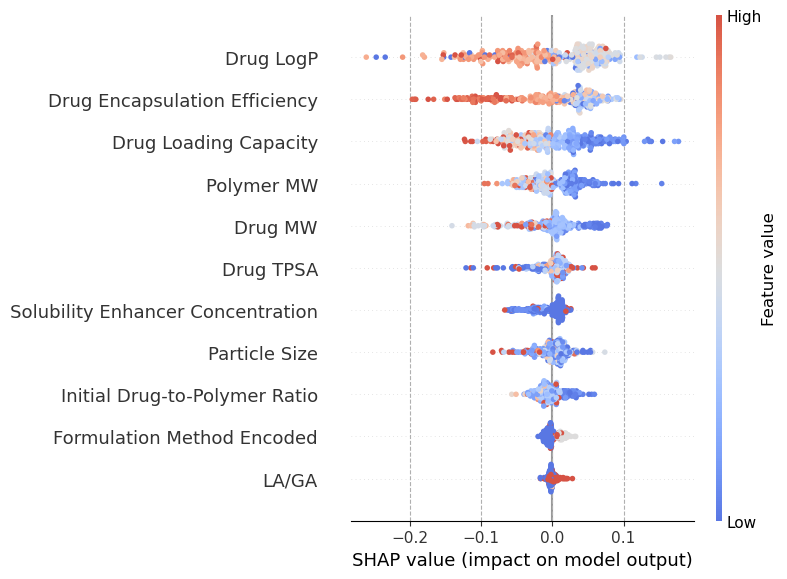

In [21]:
feature_names = ["Drug MW", "Drug TPSA", "Drug LogP", "Polymer MW",
                 "LA/GA","Initial Drug-to-Polymer Ratio", "Particle Size", "Drug Loading Capacity", "Drug Encapsulation Efficiency",
                 "Solubility Enhancer Concentration", "Formulation Method Encoded"]
# Combine stored values from all folds
combined_shap_values = np.concatenate(stored_shap_values, axis=0)
shap_values_for_plot = combined_shap_values[:, :, 1]
combined_X_test = np.concatenate(stored_shap_test_sets, axis=0)

# --- Create a lighter red-to-blue colormap ---
base_cmap = cm.get_cmap("coolwarm")  # red-to-blue
light_cmap = LinearSegmentedColormap.from_list(
    "light_coolwarm",
    base_cmap(np.linspace(0.1, 0.9, 256))  # cut off the darkest colors
)

shap.summary_plot(
    shap_values_for_plot, 
    combined_X_test, 
    feature_names=feature_names,     
    plot_type="dot",
    cmap=light_cmap,
    show=False)

# Get the current axes
ax = plt.gca()

# Add a clean, light grid
ax.grid(True, which='both', axis='x', linestyle='--')

# Optional: move grid behind points
ax.set_axisbelow(True)
plt.show()